# Visualisation de l'espace latent du β-VAE

## Introduction

CE QU'ON SOUHAITE FAIRE / POURQUOI ON SOUHAITE LE FAIRE / COMMENT ON VA LE FAIRE (DIFFERENTES METRIQUES) A PARTIR DE QUEL ARTICLE

## Visualisation de l'espace

### Importation des données

In [17]:
# don't display tensorflow warnings
import os, logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Load tensorboard for visualisation after training
%load_ext tensorboard
import tensorflow as tf

#Reset of keras session
tf.keras.backend.clear_session()  

# Check of device used and tf version
print("Tensorflow version :", tf.__version__)
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tensorflow version : 2.1.0
Please install GPU version of TF


Nous souhaitons vérifier que la version de tensorflow pour le projet est bien la 2.1. Nous regardons également sur quel dispositif les calculs sont executés. Dans notre cas, nous avons bien la bonne version de tensorflow, néanmoins nous ne disposons pas de GPU lors du développement de ce projet et faisons tourner nos calculs sur le CPU.

In [2]:
# import of usefull librairies
from collections import defaultdict
import glob 
from dataset import *
from os import path

# batch size for dataset visualization
batch_size = 64
data_dir = "/Users/jouffroy/Desktop/CEA2/dataset"
# creation of object dataset 
dataset = DataSet(data_dir, batch_size)

# relative path to data for qualitative and quantitative visualisation
path_qualitative= "/Users/jouffroy/Desktop/CEA2/vis_dataset/qualitative/"
path_quantitative = "/Users/jouffroy/Desktop/CEA2/vis_dataset/quantitative"

# relative path of csv if exist
csv_path = "/Users/jouffroy/Desktop/CEA2/dataframe_path_labels5.csv"
# creation of datafram from csv if exists, otherwise
# creation of csv file for labels
if (path.exists(csv_path)):
    df = pd.read_csv(csv_path)
else: 
    df = dataset.create_csv(csv_path)
    
# creation of generator
generator=dataset.create_generator(0.2,0.2,0.3,0.3)
# creation of training set
test_data_gen = dataset.create_flow(generator, "validation", df)
# transformation of training set flow to dataframe object
test_ds = tf.data.Dataset.from_generator(
    lambda: test_data_gen,
    output_types=(tf.float32, tf.string))

# caching and prefetching images for memory
test_data = dataset.prepare_for_training(test_ds)
# getting next training batch for visualisation
image_batch, label_batch = next(iter(test_data))

Found 43157 validated image filenames.


Plus tard dans le projet, nous aurons besoin de vérifier les valeurs de variances apprises par le modèle pour chacun des facteurs de l'espace latent. Pour cela, nous utiliserons un batch d'images comprises dans le jeu de test. C'est pourquoi il est nécessaire de récupérer le jeu de données et de créer un générateur ainsi qu'un objet tensorflow Dataset afin d'avoir un objet itérable que nous passeront dans l'encodeur pour en récupérer les valeurs des variances. La création du jeu de données a été effectué avec exactement les mêmes paramètres que lors de la création du jeu de données utilisé pour l'apprentissage des différents réseaux. Ainsi, dans le jeu de données, nous avons bien 43157 images, comme précédemment. 

In [ ]:
# creating an instance of the keras model
from variationalAutoEncoder import *

# beta used for elbo loss
beta = 1
# latent size for encoding
latent_size = 32
#shape of input images
image_shape = (128,128,1)

vae = VariationalAutoEncoder(latent_size,beta,image_shape)

Par ailleurs, il est également nécessaire d'instancier un objet VAE. Lors de l'apprentissage de nos différents réseaux, nous avons sauvegardé les poids du réseaux dans différents fichiers selon la valeur de β. Ces sauvegardes ont eu lieu toutes les vingt epochs lors de l'apprentissage, ainsi qu'à la fin de chaque entraînement. Cela nous permet par la suite de récupérer les valeurs de ces poids sauvegardés et de les charger sur le nouveau VAE instancié.

### Visualisation qualitative du démélage de l'espace latent

EXPLICATION DE A QUOI CA SERT, POURQUOI C'EST FAIT, COMMENT C'EST FAIT ( chaque ligne / chaque colonne )
COMMENT NOUS ON A FAIT (c'est à dire quel jeu de données on a utilisé, comment on a fait)

#### Lorsque le modèle est entraîné pour β=1

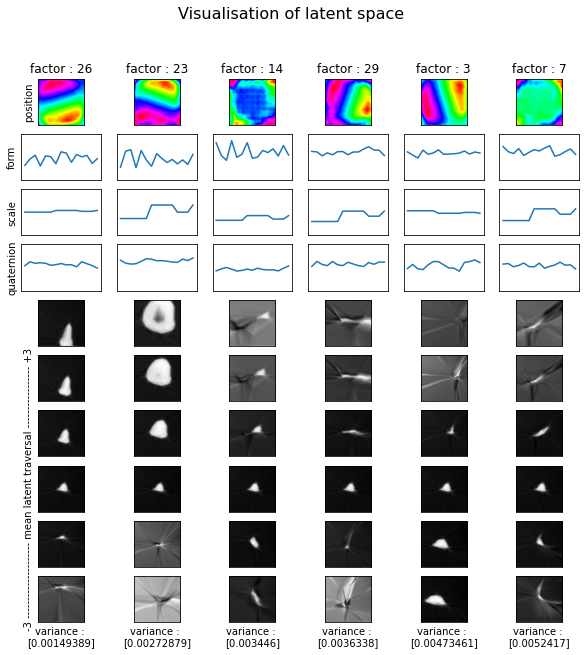

In [7]:

# load weights of the last trained model for visualizing latent space
vae.load_weights('./checkpoints/my_checkpoint/beta1')
# creating an instance of visualisation class
from latentSpace import *
visVae = LatentSpaceVisualisation(vae,path_qualitative, path_quantitative)

# getting the sorted factors of the latent space
variances = visVae.sorted_var(image_batch)[:6]
# getting the relevant dataset for qualitative visualisation
quaternions, typeform, echelleglob, position = visVae.create_dataset_qualitative_visualisation()

# getting every images that will be plot during visualisation, for each sixth first factors
pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var = visVae.get_imgs_to_plot(variances, 
                                                                                                         quaternions[0],
                                                                                                         typeform,
                                                                                                         echelleglob,
                                                                                                         quaternions,
                                                                                                         position
                                                                                                         )

# plotting the figure
visVae.plot_figure(pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var)

Les résultats obtenus lorsque β=1 coïncident relativement bien avec nos attentes. On remarque effectivement que les six premiers factors, censés être d'après l'article sur lequel on se réfère, les plus "désenmélés" possibles, encodent presque tous la position de l'objet dans l'image. Effectivement, en s'intéressant à la première ligne qui nous montre l'activation du facteur spécifié en fonction de la place du centre de l'objet dans l'image, il est possible d'interpréter que les facteurs 26 et 23 encodent la variation de l'objet sur l'axe des abscisses tandis que les facteurs 29 et 3 encodent la variation de sa position sur l'axe des ordonnées. Cela concorde par également aux images présentes à partir de la cinquième ligne et représentant la reconstruction du décodeur à partir d'une image de base en faisant varier sa moyenne apprise lors de l'encodage. 


Les lignes deux à quatre ne sont pas pertinentes 

#### Lorsque le modèle est entraîné pour β=102

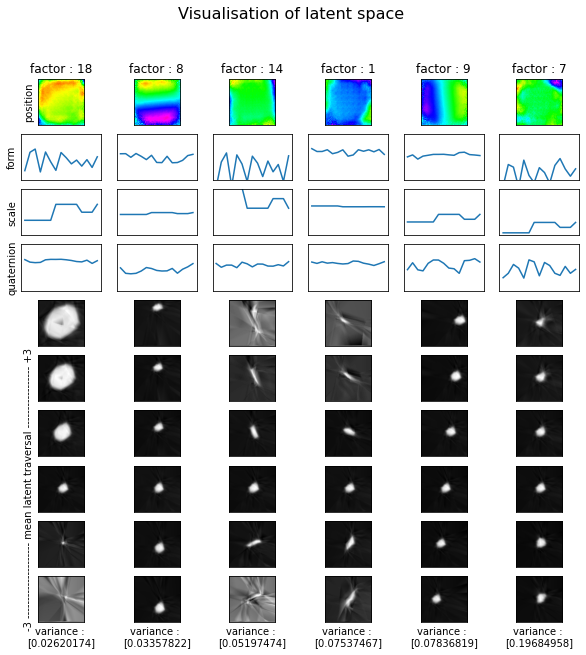

In [8]:
vae.load_weights('./checkpoints/my_checkpoint/beta102')
visVae = LatentSpaceVisualisation(vae,path_qualitative, path_quantitative)
# getting the sorted factors of the latent space
variances = visVae.sorted_var(image_batch)[:6]
# getting the relevant dataset for qualitative visualisation
quaternions, typeform, echelleglob, position = visVae.create_dataset_qualitative_visualisation()
# getting every images that will be plot during visualisation, for each sixth first factors
pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var = visVae.get_imgs_to_plot(variances, 
                                                                                                         quaternions[0],
                                                                                                         typeform,
                                                                                                         echelleglob,
                                                                                                         quaternions,
                                                                                                         position
                                                                                                         )
# plotting the figure
visVae.plot_figure(pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var)

### Visualisation quantitative du démélage de l'espace latent

Explication de la "disentanglement metric"

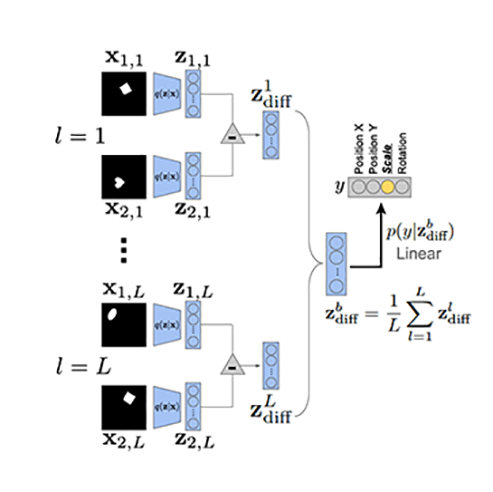

In [20]:
from PIL import Image               
# to load images
from IPython.display import display 
pil_im = Image.open('/Users/jouffroy/Desktop/CEA2/img/dis_metric.png')
display(pil_im)

In [9]:
# gatting all training and testing relevant dataset for training
train_quaternion, test_quaternion, train_scale, test_scale, train_form, test_form, train_positiony, test_positiony, train_positionx, test_positionx = visVae.create_dataset_quantitative_visualisation()
    

#### Lorsque le modèle est entraîné pour β=1

In [11]:
# creation of each relevant parameters for training
epoch_number = 50
nb_batch = 35
training_steps = 250
validation_steps = 100
# loading trained model for beta = 1
vae.load_weights('./checkpoints/my_checkpoint/beta1')
# getting generator for training set
train_data_gen = visVae.generator(nb_batch, train_positionx, train_positiony, train_form, 
                                  train_scale, train_quaternion)
# getting generator for testing set
test_data_gen = visVae.generator(nb_batch, test_positionx, test_positiony, test_form, test_scale, test_quaternion)

In [12]:
# exemple of batch from training set
print(next(iter(train_data_gen)))

(array([[0.10641833, 0.3002194 , 0.23458317, 0.62211704, 0.3251144 ,
        0.0584272 , 0.08307726, 0.76148725, 0.0846809 , 0.08850525,
        0.0690777 , 0.05679192, 0.12526348, 0.09174124, 0.31098092,
        0.05647711, 0.07519899, 0.09781188, 0.24366449, 0.09803366,
        0.25321546, 0.0865618 , 0.08873464, 1.0965798 , 0.08453465,
        0.2902661 , 1.5509357 , 0.36438328, 0.08522315, 0.5444043 ,
        0.09034614, 0.06842024]], dtype=float32), array([[0., 0., 0., 0., 1.]], dtype=float32))


In [13]:
# creation of a new sequential keras model
model = keras.Sequential()

# adding input shape to keras model, with shape (len(latent_size)) 
model.add(tf.keras.Input(shape=(32,)))
# adding output shape to keras model, with nb_class of neurons and 
# softmax activation for cross-entroy function
model.add(keras.layers.Dense(5, activation='softmax'))

# using Adagrad optimizer with learning rate = 1e-2 according to the article
opt = keras.optimizers.Adagrad(learning_rate=0.01)
# compiling the model with CategoricalCrossEntropy loss, and accuracy as metric
model.compile(optimizer=opt,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# summary the model for visualization
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 165       
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [14]:
# training the model of training set and testing on validation set
# with verbose = 0 for not displaying each results
history = model.fit(
    train_data_gen,
    validation_data = test_data_gen,
    validation_steps = validation_steps, 
    steps_per_epoch = training_steps,
    epochs = epoch_number,
    verbose = 0)

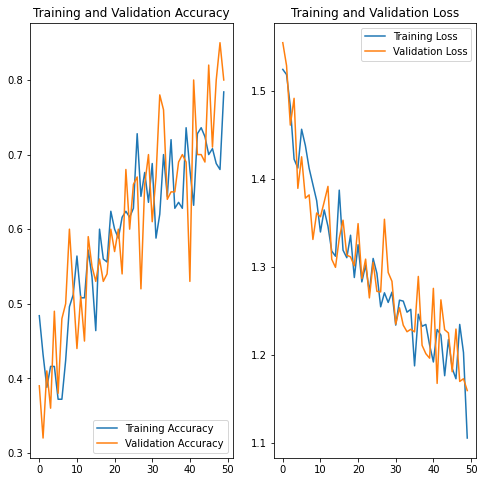

In [15]:
# printting the results of history for visualization of
# training and testing curves
import matplotlib.pyplot as plt
visVae.plot_curves_quantitative(history, epoch_number)

#### Lorsque le modèle est entraîné pour β=102

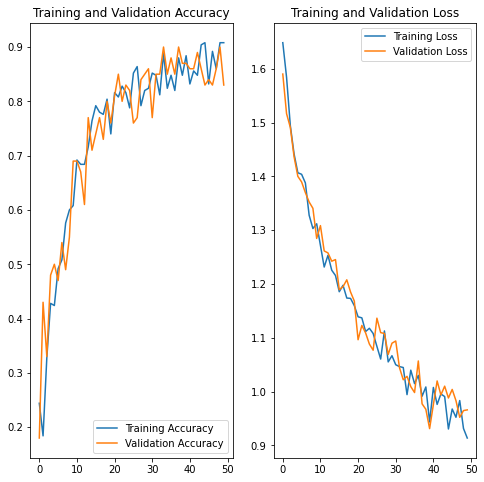

In [16]:
# loading trained model for beta = 102
vae.load_weights('./checkpoints/my_checkpoint/beta102')
# getting generator for training set
train_data_gen = visVae.generator(nb_batch, train_positionx, train_positiony, 
                                  train_form, train_scale, train_quaternion)
# getting generator for testing set
test_data_gen = visVae.generator(nb_batch, test_positionx, test_positiony, test_form, test_scale, test_quaternion)
# creation of a new sequential keras model
model = keras.Sequential()

# adding input shape to keras model, with shape (len(latent_size)) 
model.add(tf.keras.Input(shape=(32,)))
# adding output shape to keras model, with nb_class of neurons and 
# softmax activation for cross-entroy function
model.add(keras.layers.Dense(5, activation='softmax'))

# using Adagrad optimizer with learning rate = 1e-2 according to the article
opt = keras.optimizers.Adagrad(learning_rate=0.01)
# compiling the model with CategoricalCrossEntropy loss, and accuracy as metric
model.compile(optimizer=opt,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# summary the model for visualization
# creation of each relevant parameters for training
epoch_number = 50
nb_batch = 35
training_steps = 250
validation_steps = 100

# training the model of training set and testing on validation set
# with verbose = 0 for not displaying each results
history = model.fit(
    train_data_gen,
    validation_data = test_data_gen,
    validation_steps = validation_steps, 
    steps_per_epoch = training_steps,
    epochs = epoch_number,
    verbose = 0)
# printting the results of history for visualization of
# training and testing curves
import matplotlib.pyplot as plt
visVae.plot_curves_quantitative(history, epoch_number)

## Conclusion